<a href="https://colab.research.google.com/github/EmrahYener/DLMAINLPCV01_demo/blob/master/machine_translation_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Translation**

Machine translation (MT) is the task of automatically translating text or speech from one natural language to another. MT is a subfield of NLP that leverages the disciplines of artificial intelligence, information theory, computer science, and statistics.

To build an MT system, we can find different frameworks with statistical machine translation (SMT) and neural machine translation (NMT).

SMT replaces classic rule-based MT systems with models that learn translation through examples. Translations in SMT are generated on the basis of statistical models whose parameters are derived from the analysis of bilingual text corpora.

NMT uses an artificial neural network to learn a statistical
model for MT. Unlike a phrase-based SMT system, an NMT system consists of a single, large neural network that reads a sentence and outputs a translation. Normally an NMT system is built on bidirectional recurrent neural networks (RNNs) using an encoder-attention-decoder architecture  [[1]](#scrollTo=hC1nskpFvqjO).

Since NMT is becoming increasingly popular, there are already many toolkits available. This notebook shows an example of NMT with an encoder-attention-decoder architecture, i.e. a sequence-to-sequence network with an attention mechanism.

Some of the explanations, codes and pictures used in this notebook are taken from [[2]](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html).






## **NMT with sequence-to-sequence network**
An RNN is a network that operates on a sequence and uses its own output as input for subsequent steps.

A sequence-to-sequence network (also denoted as seq2seq network or encoder-decoder network) is a model consisting of two RNNs which are denoted as encoder and decoder. The encoder reads an input sequence and outputs a single vector, called context vector. The context vector summarizes the entire input sequence into a single fixed-length vector. The decoder reads that vector to produce an output sequence.

Unlike sequence prediction with a single RNN, where every input corresponds to an output, the seq2seq model frees us from sequence length and order, which makes it ideal for translation between two languages.

There are two common RNN architectures, long short-term memory (LSTM) and gated recurrent units (GRU). In this example, we will use use GRU architecture. For more detail about GRU, please refer to [[3]](https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be).






In this example, we will also use an attention mechanism to improve the model efficency. With an attention mechanism, the decoder learns to focus over a specific range of the input sequence.

For machine translation with a seq2seq network, we will apply the following steps:

* Upload dataset
* Import libraries
* Create classes and functions
* Perform model training
* Perform model evaluation
* Visualize attention

For more details about the seq2seq architecture, please refer to [[4]](https://arxiv.org/abs/1409.3215).

### Upload dataset
The dataset of this project ``eng-fra.txt`` contains 135,842 tab separated English-to-French translation pairs [[5]](https://www.manythings.org/anki/).

To upload the dataset, we clone the related IU GitHub portfolio [[6]](https://github.com/iubh/DLMAINLPCV01).


This dataset contains two sentences in each line. The first sentence of each line is an English text and the second sentence is its corresponding French translation. You can see a few example sentences below:

* You are free to go.	Vous êtes libres de partir.
* You are impossible.	Vous êtes insupportable.
* You are overworked.	Tu es surmené.
* You are very brave.	Tu es très courageux.


In [1]:
# Clone the IH GitHub portfolio
!git clone https://github.com/iubh/DLMAINLPCV01.git

Cloning into 'DLMAINLPCV01'...
remote: Enumerating objects: 819, done.
remote: Counting objects: 100% (179/179), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 819 (delta 142), reused 160 (delta 132), pack-reused 640
Receiving objects: 100% (819/819), 86.65 MiB | 14.52 MiB/s, done.
Resolving deltas: 100% (393/393), done.


### Import libraries
We import libraries to prepare the dataset and create a seq2seq network. Also, we use the ``matplotlib`` library to visualize the diagrams of the training loss and the attention mechanism.

In [2]:
# Import "open" library to open the dataset "eng-fra.txt"
from io import open

# Import the "unicodedata" library to normalize the dataset "eng-fra.txt"
import unicodedata

# Import "re" library to use regex in the function "normalizeString" 
import re

# Import "random" library to choose or print random sentence pairs
import random

# Import "pytorch" libraries for creating seq2seq network
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# Define PyTorch device to run CUDA operations. If CUDA is not available, PyTorch uses CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Import "time" and "math" libraries to print time elapsed and time remaining with the "timeSince" function
import time
import math


# Import "matplotlib" libraries to visualize training loss and attention
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

### Prepare dataset
In this section, we prepare our dataset to be processed by the seq2seq network.

We create the following class:
* ``Language``

We create the following functions:
* ``normalizeString``
* ``readLanguages``
* ``filterPairs``


#### Create ``Language`` class
The class ``Language`` contains the following functions:
*  ``__init__``: initializes a language instance.
* ``addWord``: is a helper function that runs inside the function ``addSentence``. It creates a mapping between words and corresponding indexes and saves the mapping to the dictionaries ``word2index`` and ``index2word``. The function also creates a mapping between words and their occurrences and saves the mapping to the dictionary ``word2count``.
* ``addSentence``: runs the function ``addWord`` over each sentence.


In [3]:
# We assign the first two indexes to SOS (start-of-sequence) and EOS (end-of-sequence) tokens
SOS_token = 0
EOS_token = 1

# This class contains 3 functions. 
## "__init__" is used to initialize a language instance
## "addWord" is used to create a mapping between words and indexes. It also counts the frequency of each word.
## "addSentence" is used to run the function "addWord" over each sentence.
class Language:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.word_index = 2   # The first two index numbers are assigned to SOS and EOS. The variable "word_index" starts from 2.

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.word_index
            self.word2count[word] = 1
            self.index2word[self.word_index] = word
            self.word_index += 1
        else:
            self.word2count[word] += 1
        
        # for k,v in word2index.items():
        #   print(k, v)
    
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

#### Create ``normalizeString`` function
In this section, we create the function ``normalizeString`` to normalize the dataset. 
It is used to lowercase the string, remove non-letter characters and exclamation marks. Also, it executes the helper function ``removeStringAccent``.

The helper function ``removeStringAccent`` is used to remove accents from a given string. In the French alphabet, some letters have accent marks such as â, ê, î, ô, û. The function ``removeStringAccent`` takes a unicode string and returns a string without accents. You can see an example below:
* With accent: 'Découvrez tous les logiciels à télécharger'

* Without accent: 'Decouvrez tous les logiciels a telecharger'

In [4]:
# Define a helper function to remove string accents
def removeStringAccent(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Define the function "normalizeString" 
## Execute the function "removeStringAccent" 
## Lowercase the characters
## Insert whitespaces after punctuation marks.
def normalizeString(s):
    s = removeStringAccent(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

#### Create ``readLanguages`` function
At the [Upload dataset](#scrollTo=BjQmYSv_L1rl) step, we have cloned the IU GitHub portfolio. As explained in that section, the dataset ``eng-fra.txt`` contains sentence pairs. The function ``readLanguages`` reads the dataset, normalizes the sentence pairs and defines the language of the first and second sentence. 

This function has 3 inputs:
* ``language1`` and ``language2``: are string variables. They allow us to define the language of the first and second sentences of each sentence pair.
* ``reverse``: is a boolean variable. The sentence pair order is first English and then French to be used for an English-French translation. If we want to change the order of sentence pairs to be used for a French-English translation, we set ``reverse=True``.


This function normalizes sentence pairs with the function ``normalizeString`` and saves them to the list ``pairs``. 

This function also calls the ``Language`` class and initializes two language instances ``input_language`` and ``output_language``.

It returns three outputs ``input_language``, ``output_language``and ``pairs``.


In [5]:
# Create the function "readLanguages" to:
## read the dataset "eng-fra.txt"
## create English-French sentence pairs (or French-English if "reverse=True") 
## initialize language instances "input_language" and "output_language"
def readLanguages(language1, language2, reverse=False):
    print("Reading lines...")

    # Read the dataset and split into lines
    lines = open('/content//DLMAINLPCV01/data/nlp/%s-%s.txt' % (language1, language2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make language instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_language = Language(language2)
        output_language = Language(language1)
    else:
        input_language = Language(language1)
        output_language = Language(language2)


    return input_language, output_language, pairs

#### Create ``filterPairs`` function
We have created functions to read our dataset. However, our dataset contains 135,842 sentence pairs. To quickly setup a first MT system, we create a subset of these sentence pairs using the function ``filterPairs``. The purpose of this function is to trim the dataset to only relatively short and simple sentences.

To filter the sentence pairs by length and content, we use two variables, the integer ``max_length`` and the list ``eng_prefixes``.

The integer ``max_length`` defines the maximum length of the sentences. In this example, we set ``max_length=10``.

The list ``eng_prefixes`` is used to choose only the sentences which begin with pronouns and a form of ``to be``.

In [6]:
# Define the integer ``max_length`` and set to 10
max_length = 10

# Define the list ``eng_prefixes``
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re " )

# Define the helper function "filterPair" to filter sentence pairs according to ``max_length`` and ``eng_prefixes``
## Return the given sentence pair "p" if it meets the conditions
def filterPair(p):
    return len(p[0].split(' ')) < max_length and \
        len(p[1].split(' ')) < max_length and \
        p[1].startswith(eng_prefixes)

# Create the function "filterPairs" 
## Run the function "filterPair" over all sentence pairs
## Return all filtered sentence pairs
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]



#### Create ``tensorsFromPair`` function
Since PyTorch processes tensors and we , we need to convert our sentence pairs to tensors. In our case, we define two 2-dimensional In this section, we will create the function ``tensorsFromPair`` which creates two tensors where the key is the word index and the value is the corresponding word vector. It returns the tensors ``input_tensor`` which represents the input language and ``output_tensor`` which represents the output language.

In [7]:
# Create the function "tensorsFromPair()"
## This function takes a sentence pair as input
## Executes the helper function "tensorFromSentence()" over the given sentence pair
## The first sentence of the given pair "pair[0]" is returned as "input_tensor" and second sentence "pair[1]" is "target_tensor"
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_language, pair[0])
    target_tensor = tensorFromSentence(output_language, pair[1])
    return (input_tensor, target_tensor)

# Create the helper function "tensorFromSentence()"
## It executes the helper function "indexesFromSentence()" over a given sentence
## It creates the 2D tensor "indexes" which contains word indexes with corresponding language 
## The data type "torch.long" states that the returned variable is a tensor
def tensorFromSentence(language, sentence):
    indexes = indexesFromSentence(language, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

# Create the helper function "indexesFromSentence()"
## It iterates over each sentence and returns the index number of each word
def indexesFromSentence(language, sentence):
    return [language.word2index[word] for word in sentence.split(' ')]

#### Execute functions and create dataset
In the previous steps, we cloned the GitHub portfolio and created the functions to prepare the dataset. Now we create the function ``prepareData`` which executes the previous functions and performs the following tasks:

* Read text file and split lines into pairs
* Normalize text, filter by length and content
* Create the list ``pairs`` which contains sentence pairs
* Return the instances ``input_language`` and ``output_language`` of the class ``Language`` to provide word-index mappings for both languages
* Return the list ``pairs`` containing our sentence pairs after our normalization steps.

In [27]:
# Create the function "prepareData"
def prepareData(language1, language2, reverse=False):
    input_language, output_language, pairs = readLanguages(language1, language2, reverse)
    print("\nRead %s sentence pairs" % len(pairs))

    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
 
    for pair in pairs:
        input_language.addSentence(pair[0])
        output_language.addSentence(pair[1])

    print("\nCounted words:")
    print("Input language and word index:",input_language.name, input_language.word_index)
    print("Output language and word index:", output_language.name, output_language.word_index)

    return input_language, output_language, pairs


# Run the function "prepareData" and print a random sentence pair
input_language, output_language, pairs = prepareData('eng', 'fra', True)
print("""\nA random sample from the list "pairs": """)
print(random.choice(pairs))

Reading lines...

Read 135842 sentence pairs
Trimmed to 10599 sentence pairs

Counted words:
Input language and word index: fra 4345
Output language and word index: eng 2803

A random sample from the list "pairs": 
['j ai peur des chiens .', 'i m afraid of dogs .']


In [9]:
# Now below we see the first 20 keys and values of the dictionary "index2word"
for k,v in input_language.index2word.items():
  print(k, v)
  if k==19:
    break

0 SOS
1 EOS
2 j
3 ai
4 ans
5 .
6 je
7 vais
8 bien
9 ca
10 va
11 suis
12 gras
13 gros
14 en
15 forme
16 touche
17 !
18 touchee
19 malade


In [25]:
print(input_language.word_index)

4345


In [30]:
print(input_language.word2index["suis"])


11


### Prepare seq2seq network

We have now completed the preparation steps of our dataset. Now we create the seq2seq network.

We create the following classes:
* ``EncoderRNN``
* ``AttnDecoderRNN``

We create the following functions:
* ``tensorsFromPair``
* ``train`` 
* ``timeSince``
* ``trainIters``
* ``showPlot``
* ``evalute``
* ``evaluateRandomly``

#### Create ``EncoderRNN`` class
As we explained before, our seq2seq model contains two RNNs. The first RNN is called encoder and the second one is called decoder. The encoder reads the input sequence until the token <EOS> occurs and sends the most relevant information in form of one vector, i.e. the context vector, to the decoder. Then the decoder generates the output sequence.

The figure below demonstrates how each word of the English sentence "how are you" together with the start token ``SOS`` and the end token ``EOS`` is input of the encoder. Since the sequence has 5 elements, it takes 5 timesteps to read this entire sequence. Each timestep:

* 1 token is input of 1 GRU. , 
* does a transformation on its hidden state, then sends that hidden state output to the next timestep. We move from one timestep to the next (from one token to the other).


![encoder](https://drive.google.com/uc?export=view&id=1A7Rkj9KKsdAttPqR7cDA3_d922vbtMMu)

########
An Embedding layer is essentially just a Linear layer. So you could define a your layer as nn.Linear(1000, 30), and represent each word as a one-hot vector, e.g., [0,0,1,0,...,0] (the length of the vector is 1,000).

As you can see, any word is a unique vector of size 1,000 with a 1 in a unique position, compared to all other words. Now giving such a vector v with v[2]=1 (cf. example vector above) to the Linear layer gives you simply the 2nd row of that layer.

nn.Embedding just simplifies this. Instead of giving it a big one-hot vector, you just give it an index. This index basically is the same as the position of the single 1 in the one-hot vector.
########


In [10]:
# Create the class "EncoderRNN" that holds our weights, bias, and method for the forward step. 
# input_size: is the number of inputs. That means the size of sentences. We define it from total word index numbers.
# hidden_size: is a hyperparameter. It defines the size of the hidden state (the length of the output vector of the encoder RNN). 
## In the training phase, we will set it to 256. Then the hidden state at each time step will be a vector of length 256.
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        # Initialize a 2d-array
        ## When class is called, pytorch automatically fills this 2d-array with random weight parameters
        self.embedding = nn.Embedding(input_size, hidden_size)

        # Create gated recurrent unit (GRU) with input_dim=hidden_size and hidden_dim=hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size)
    
    # This function shapes the input and output format of the encoder GRU network
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        input_gru = embedded
        input_gru, hidden = self.gru(input_gru, hidden)
        return  input_gru, hidden
    
    # Create a tensor filled with zeros with a size of 1x256
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

#### Create ``AttnDecoderRNN`` class
The decoder is another RNN that takes the encoder's output vector, i.e. the context vector, and outputs a sequence of words [?????] to create the translation.

In the simplest seq2seq decoder, we use only last output of the encoder. This last output is sometimes called the context vector as it encodes context from the entire sequence. This context vector is used as the initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string <SOS> token, and the first hidden state is the context vector (the encoder’s last hidden state).

![encoder](https://drive.google.com/uc?export=view&id=1dxoPoRB3K3z5DIeu__Kvk8ez8b5fvakz)


As we have explained before, we will use an attention mechanism to improve the model efficiency. Attention allows the decoder network to “focus” on a different part of the encoder’s outputs for every step of the decoder’s own outputs. First, we calculate a set of attention weights. These will be multiplied by the encoder output vectors to create a weighted combination. The result (called attn_applied in the code) should contain information about that specific part of the input sequence, and thus help the decoder choose the right output words.

![encoder](https://i.imgur.com/1152PYf.png)

In [11]:
# Create the class "AttnDecoderRNN"
## This class contains the functions for the decoder RNN and the attention mechanism 
## hidden_size: is a hyperparameter. It defines the length of the input vector. 
### Since the output size of the encoder should match the input size of the decoder, decoder "hidden_size" and the encoder "hidden_size" has to be the same.
## output_size: is the size of the output vector. That means the total number of words. We define it from the variable word_index.
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=max_length):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    # This function shapes the input and output format of the decoder RNN, defines the activation functions and also calculates the attention weights
    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    # Create a tensor filled with zeros with a size of 1x256
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

#### Create ``train`` function
We have created the functions of encoder and decoder. In this section, we create the function ``train`` to run the input sentence through the encoder, and keep track of every output and the latest hidden state (output of the previous timestep). Then the decoder is given the <SOS> token as its first input, and the last hidden state of the encoder as its first hidden state.

In this function, we will also use the teacher forcing concept which uses the real target outputs as each next input, instead of using the decoder’s guess as the next input. Teacher forcing improves the training process.

In [12]:
# Turn teacher_forcing_ratio up to use more of it.
teacher_forcing_ratio = 0.5


def calculate_loss(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=max_length):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

#### Create ``timeSince`` function
In this section, we create the function ``timeSince`` which prints time elapsed and estimated time remaining given the current time and progress %.


In [13]:
# Create the function "timeSince"
## It calculates and returns the time elapsed and estimated time
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

# Create the helper function "asMinutes". 
## It returns the time elapsed as the minutes and runs inside the "timeSince" function
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

#### Create ``trainIters`` function
We have created all functions to train our model. In this section we create the function ``trainIters`` which executes the previous functions and performs the following tasks:

* Starts a timer
* Initializes optimizers for encoder and decoder. We will use the stochastic gradient descent (SDG) method.
* Initializes criterion for loss calculation. We will use negative log-likelihood loss (NLLLoss)
* Creates set of training pairs
* Starts empty losses array for plotting
* Calls the function ``train`` many times and occasionally prints the progress (% of examples, time so far, estimated time) and average loss.

In [22]:
#Create the function "trainIters"
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = calculate_loss(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)
    print(input_tensor)
    print(target_tensor)


#### Create ``showPlot`` function
Plotting is done with matplotlib, using the array of loss values plot_losses saved while training.

In [15]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

#### Create ``evalute`` function
Evaluation is mostly the same as training, but there are no targets so we simply feed the decoder’s predictions back to itself for each step. Every time it predicts a word we add it to the output string, and if it predicts the EOS token we stop there. We also store the decoder’s attention outputs for display later.

In [16]:
def evaluate(encoder, decoder, sentence, max_length=max_length):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_language, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_language.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

#### Create ``evaluateRandomly`` function
We can evaluate random sentences from the training set and print out the input, target, and output to make some subjective quality judgements:

In [17]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('Input sentence: ', pair[0])
        print('Correct translation: ', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('Predicted translation: ', output_sentence)
        print('')

### Perform model training
With all these helper functions in place (it looks like extra work, but it makes it easier to run multiple experiments) we can actually initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small dataset we can use relatively small networks of 256 hidden nodes and a single GRU layer. 

0m 28s (- 0m 0s) (1500 100%) 3.3615
tensor([[ 210],
        [ 383],
        [ 925],
        [2625],
        [   5],
        [   1]], device='cuda:0')
tensor([[ 129],
        [  78],
        [  61],
        [ 532],
        [1191],
        [   5],
        [   4],
        [   1]], device='cuda:0')


<Figure size 432x288 with 0 Axes>

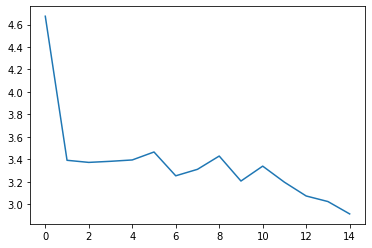

In [23]:
# We set the number of hidden layers to 256
hidden_size = 256

# We initialize our encoder RNN
## input_size of our encoder RNN is the length of our word index of the input language. In our example, the input language is French and the word index is 4345
## hidden_size of our encoder RNN is 256, which is a hyperparameter we set
### It defines the number of features of the hidden state
## we connect our encoder RNN to device (if GPU available GPU, if not, CPU.)
encoder1 = EncoderRNN(input_language.word_index, hidden_size).to(device)

# We initialize our decoder RNN
## input_size of our decoder RNN is 256, which is same as the output size of encoder RNN
## output_size of our decoder RNN is the length of our word index of the output language. In our example, the output language is English and the word index is 2803
## we connect our encoder RNN to device (if GPU available GPU, if not, CPU.)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_language.word_index, dropout_p=0.1).to(device)

# Now encoder and decoder RNNs are ready.
## We execute the function "trainIters()" to perform the training process.
## we set encoder and decoder parametes. 
## We set training iterations to 20000
## We print process for every 5000 iterations. 
## We show training loss for every 100 iterations. 
## The learning rate is 0.01
trainIters(encoder1, attn_decoder1, 1500, print_every=1500, plot_every=100, learning_rate=0.01)

### Perform model evaluation

In [ ]:
#  Execute the function "evaluateRandomly()" to print random results and to compare them with the correct translations
evaluateRandomly(encoder1, attn_decoder1)

Input sentence:  vous etes en securite .
Correct translation:  you re safe .
Predicted translation:  you re safe . <EOS>

Input sentence:  je suis desole mais vous devez partir .
Correct translation:  i m sorry but you need to leave .
Predicted translation:  i m sorry but you to have . <EOS>

Input sentence:  elle ecrit constamment des lettres .
Correct translation:  she is constantly writing letters .
Predicted translation:  she is afraid of the . <EOS>

Input sentence:  je ne suis pas vraiment occupe .
Correct translation:  i m not really busy .
Predicted translation:  i m not busy busy busy . <EOS>

Input sentence:  nous sommes prudentes .
Correct translation:  we re careful .
Predicted translation:  we re broke . <EOS>

Input sentence:  j attends ton aide .
Correct translation:  i m waiting for your help .
Predicted translation:  i m doing your your help . <EOS>

Input sentence:  je suis extremement gras .
Correct translation:  i m extremely fat .
Predicted translation:  i m a too 

### Visualize attention
A useful property of the attention mechanism is its highly interpretable outputs. Because it is used to weight specific encoder outputs of the input sequence, we can imagine looking where the network is focused most at each time step.

You could simply run plt.matshow(attentions) to see attention output displayed as a matrix, with the columns being input steps and rows being output steps:

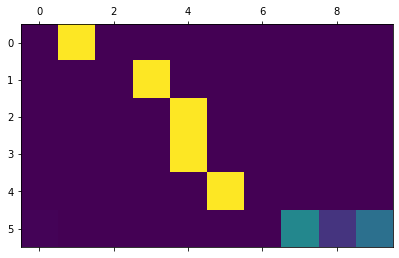

In [ ]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

# plt.title('Confusion matrix')
# plt.colorbar()
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
plt.show()


For a better viewing experience we will do the extra work of adding axes and labels:

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


input = elle a cinq ans de moins que moi .
output = she is two years older than me . <EOS>


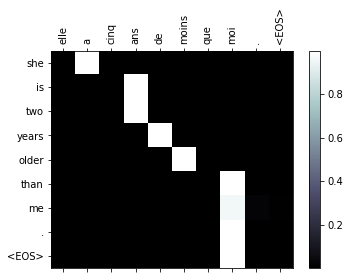

input = elle est trop petit .
output = she is too too . <EOS>


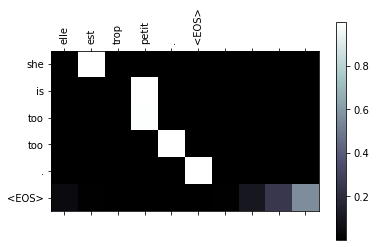

input = je ne crains pas de mourir .
output = i m not going to die . <EOS>


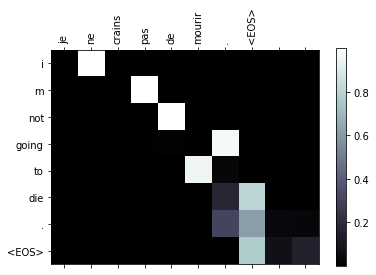

input = c est un jeune directeur plein de talent .
output = he is a very of a of . . <EOS>


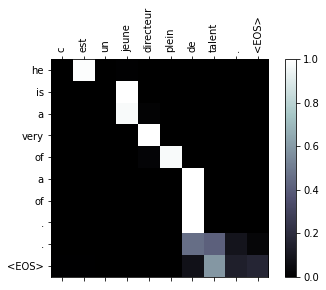

In [ ]:
evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

# **References**

- [1] NLP and Computer Vision_DLMAINLPCV01 Course Book
- [2] https://opennmt.net/
- [3] https://github.com/OpenNMT/OpenNMT-py#quickstart


https://pytorch.org/docs/stable/generated/torch.nn.GRU.html

https://stackoverflow.com/questions/59085745/what-is-the-inputs-to-a-torch-nn-gru-function-in-pytorch

.view()
https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html

https://pytorch.org/docs/stable/tensor_view.html





Copyright © 2022 IU International University of Applied Sciences

# Notes for me
It is necessary to have both the model, and the data on the same device, either CPU or GPU, for the model to process data. Data on CPU and model on GPU, or vice-versa, will result in a Runtime error.

You can set a variable device to cuda if it's available, else it will be set to cpu, and then transfer data and model to device :

In [ ]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
data = data.to(device)

In [ ]:
# My code
hidden_size = 256
encoder1 = EncoderRNN(input_lang.word_index, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.word_index, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 20000, print_every=5000, plot_every=100, learning_rate=0.01)



Consider the sentence “Je ne suis pas le chat noir” → “I am not the black cat”. Most of the words in the input sentence have a direct translation in the output sentence, but are in slightly different orders, e.g. “chat noir” and “black cat”. Because of the “ne-pas” construction in the French language, there is also one more word in the input sentence. It would be difficult to produce a correct translation directly from the sequence of input words.

![seq2seq](https://raw.githubusercontent.com/iubh/DLMAINLPCV01/master/data/nlp/seq2seq.png)

